/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


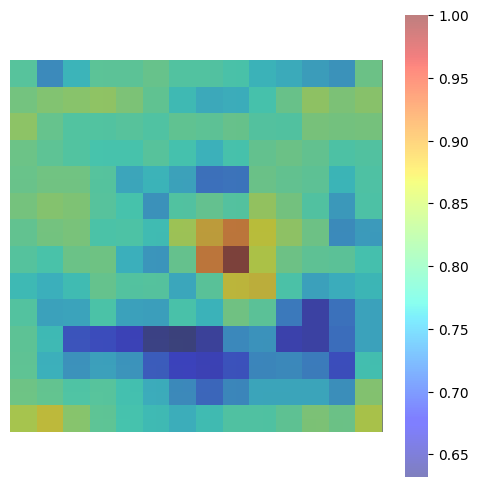

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.models as models
from torch.utils.data import DataLoader
from torchvision.datasets import CIFAR10
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# ===============================
# CNN Feature Extractor using Pretrained VGG16
# ===============================
class VGGFeatureExtractor(nn.Module):
    def __init__(self):
        super(VGGFeatureExtractor, self).__init__()
        vgg16 = models.vgg16(pretrained=True)  # Load pretrained VGG16 model
        # Extract only convolutional layers (ignore classifier/fc layers)
        self.feature_extractor = nn.Sequential(*list(vgg16.features.children())[:30])

    def forward(self, x):
        # Pass image through convolutional layers to get feature maps
        return self.feature_extractor(x)  # Output shape: (batch_size, 512, 14, 14)

# ===============================
# Attention Mechanism Over Feature Map
# ===============================
class AttentionModule(nn.Module):
    def __init__(self, feature_dim):
        super(AttentionModule, self).__init__()
        self.W = nn.Linear(feature_dim, feature_dim)  # Linear transformation layer for feature importance
        self.v = nn.Linear(feature_dim, 1)            # Outputs scalar attention score per spatial location

    def forward(self, feature_map):
        # feature_map shape: (batch, channels=512, height=14, width=14)
        batch, channels, height, width = feature_map.shape
        # Flatten spatial dimensions and transpose: (batch, H*W, C)
        feature_map = feature_map.view(batch, channels, -1).permute(0, 2, 1)

        # Apply linear transformation and non-linearity
        attention_scores = torch.tanh(self.W(feature_map))  # Shape: (batch, H*W, C)
        attention_scores = self.v(attention_scores).squeeze(-1)  # Shape: (batch, H*W)

        # Compute normalized attention weights using softmax
        attention_weights = torch.softmax(attention_scores, dim=1).view(batch, 1, height, width)

        # Compute weighted sum of features: (batch, C, 1)
        attended_features = feature_map.permute(0, 2, 1) @ attention_weights.view(batch, height * width, 1)

        return attended_features.squeeze(-1), attention_weights  # Output: (batch, C), (batch, 1, H, W)

# ===============================
# Visualization of Attention as Heatmap on Image
# ===============================
def visualize_attention(image, attention_map):
    # Normalize attention map for display
    attention_map = attention_map.squeeze(0).cpu().detach().numpy()
    attention_map = attention_map / np.max(attention_map)

    # Plot attention heatmap over original image
    plt.figure(figsize=(6, 6))
    sns.heatmap(attention_map, cmap='jet', alpha=0.5)  # Overlay attention
    plt.imshow(image.permute(1, 2, 0).cpu().numpy(), alpha=0.6)  # Show original image
    plt.axis('off')
    plt.show()

# ===============================
# Load CIFAR-10 Test Set for Demonstration
# ===============================
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize CIFAR images to 224x224 for VGG
    transforms.ToTensor()
])

# Download and prepare CIFAR-10 dataset
dataset = CIFAR10(root='./data', train=False, download=True, transform=transform)
dataloader = DataLoader(dataset, batch_size=1, shuffle=True)

# ===============================
# Initialize Pretrained Feature Extractor and Attention Module
# ===============================
feature_extractor = VGGFeatureExtractor().eval()             # Use eval mode to disable dropout/batchnorm updates
attention_module = AttentionModule(feature_dim=512).eval()   # Feature dim = 512 from VGG16

# ===============================
# Run Attention Visualization on One Sample
# ===============================
image, label = next(iter(dataloader))                    # Get one image-label pair from CIFAR-10 test set
features = feature_extractor(image)                      # Extract deep CNN features
attended_features, attention_map = attention_module(features)  # Apply attention over feature map

# Visualize attention heatmap over original image
visualize_attention(image[0], attention_map[0])

Summary of Pipeline:

    Pretrained VGG16 is used as a feature extractor, removing its classification layers.

    An attention module learns to assign importance to different spatial regions (14×14) of the image features.

    The weighted sum of spatial features is computed using attention weights to create a focused feature representation.

    The attention weights are visualized as a heatmap overlaid on the original input image.